In [93]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 

### Define functions

In [68]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[2]-step,step):
        d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
        count +=1
    return d_avg

In [69]:
def get_task_variables(data:SpikeData,bhv:BhvData):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    cgroup = "all"
    in_out='in'
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]
    # print("Number of clusters: %d" % len(data.clustersgroup))
    #print("Number of %s units: %d" % (cgroup, len(neurons)))
    task = task[task['in_out']==in_out]


    return task, trial_idx

In [70]:
def get_trials_by_sample(task,feature,trial_idx,bhv,data):
    sample_trials = {"o1":np.array([]),"o5":np.array([]),"c1":np.array([]),"c5":np.array([])}
    for key_sample in sample_trials.keys():
        sample_trials[key_sample]=np.unique(task.loc[task['sample'].str.contains(key_sample, case=False)]['trial_idx'].values)

    test_stimuli = bhv.test_stimuli[trial_idx][sample_trials[feature]]
    code_numbers = data.code_numbers[trial_idx][sample_trials[feature]]
    code_samples = data.code_samples[trial_idx][sample_trials[feature]]
    sp_samples = data.sp_samples[trial_idx][sample_trials[feature]]
    return test_stimuli,code_numbers,code_samples,sp_samples,sample_trials

In [71]:
def delete_match(test_stimuli):
    bool_m = np.where(np.isnan(test_stimuli),0,1)
    bool_m = np.concatenate([bool_m,np.ones((bool_m.shape[0],1))],axis=1)
    bool_diff = bool_m[:,:-1] - bool_m[:,1:] 
    good_tr = np.where(bool_diff == 1, False,bool_m[:,:-1]).astype(bool)
    test_stimuli = np.where(good_tr,test_stimuli,np.nan).astype(str)
    return test_stimuli

### Compute tuning

In [72]:
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

### Color and direction selectivity

* 3-way ANOVA
* with sample identity (A, B, C or D), test color, and test direction as factors
* Only included non-matching test stimuli
* Period selectivity for each neuron: fixed time window between 100 and 400 ms following test onset
* main effect of (either factor) and/or (interaction between direction/color and sample identity)

In [73]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [74]:
df: Dict[str, list] = defaultdict(list)
sp_avg_features = []
for n_bhv,n_sp in zip(paths_bhv[7:8],paths_sp[7:8]):
    sp_avg_all = []
    # Read data
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    task, trial_idx = get_task_variables(data,bhv)
    n_neurons = data.sp_samples.shape[1]
    for feature in ['c1','c5','o1','o5']:    
     
        if feature == 'c1' or feature == 'c5':
            test_color = '1'
            color_orient = 1
            if feature == 'c5':
                test_color = '5'
        else:
            test_orient = '1'
            color_orient = 0
            if feature == 'o5':
                test_orient = '5'

        stim_num=['1','2','3','4','5','6','7','8']


        # Do not take into account trials in wich the match is in the first test
        task = task[task['n_test_stimuli'] > 1]
        test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
        test_stimuli = delete_match(test_stimuli) # select only non-matching tests

        shift_sp = []
        for i_stim in stim_num:
            i_trial, i_test = np.where(np.char.find(test_stimuli,i_stim)==color_orient)
            tests_on = code_samples[i_trial,i_test+6].astype(int)
            sp_stim = sp_samples[i_trial]
            shifts = tests_on[:,np.newaxis]
            sp_tests = SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,:, 100:400]
            shift_sp.append(sp_tests.mean(axis=0))
            n_spikes = np.nansum(sp_stim,axis=2)
            for i, tr in enumerate(i_trial):
                sample = task[task['trial_idx']==sample_trials[feature][tr]]['sample'].values[0]
                # I do not take into account trials with 0 spikes
                bool_active_neu = np.where(n_spikes[i] >0, True,False)
                neuron = (np.arange(0,n_neurons)[bool_active_neu]).tolist()
                
                # complete df
                df["sample"] += [sample]*sum(bool_active_neu)
                df['fr'] += (np.mean(sp_tests[i],axis=1)[bool_active_neu]).tolist()
                df['neuron'] += neuron
                if color_orient == 1:
                    df["test_color"] += [test_color]*sum(bool_active_neu)
                    df["test_orient"] += [i_stim]*sum(bool_active_neu)
                if color_orient == 0:
                    df["test_color"] += [i_stim]*sum(bool_active_neu)
                    df["test_orient"] += [test_orient]*sum(bool_active_neu)

        shift_sp=np.array(shift_sp)

        sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
        sp_avg = np.mean(sp_avg,axis=2)

        sp_avg_all.append(sp_avg)
    sp_avg_all = np.concatenate(sp_avg_all,axis=1)
    sp_avg_features.append(sp_avg_all)
df = pd.DataFrame(df)

/tmp/ipykernel_132729/4054691977.py:6: RuntimeWarning: invalid value encountered in cast
  test_stimuli = np.where(good_tr,test_stimuli,np.nan).astype(str)


In [90]:
color_selec_neu = []

for i_neu in range(n_neurons):
    df_neu = df[df['neuron']==i_neu].reset_index(drop=True)
    #perform three-way ANOVA
    # model = ols("""fr ~ C(sample) + C(test_color) + C(test_orient)+ C(sample):C(test_color) + C(sample):C(test_orient) + C(test_color):C(test_orient)""", data=df_neu).fit()
    model = ols("""fr ~ C(sample) + C(test_color) + C(test_orient) + C(sample):C(test_color) + C(sample):C(test_orient) + C(test_color):C(test_orient)""", data=df_neu).fit()

    anova_res = sm.stats.anova_lm(model, typ=3)
    anova_p = anova_res.loc[:,'PR(>F)']
    signif = np.any(np.array([anova_p['C(test_color)'],anova_p['C(sample):C(test_color)']])<0.05)
    color_selec_neu.append(signif)


/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance 

In [89]:
df_neu = df[df['neuron']==i_neu].reset_index(drop=True)
#perform three-way ANOVA
# model = ols("""fr ~ C(sample) + C(test_color) + C(test_orient)+ C(sample):C(test_color) + C(sample):C(test_orient) + C(test_color):C(test_orient)""", data=df_neu).fit()
model = ols("""fr ~ C(sample, Sum) + C(test_color, Sum) + C(test_orient, Sum) + C(sample, Sum):C(test_color, Sum) + C(sample, Sum):C(test_orient, Sum) + C(test_color, Sum):C(test_orient, Sum)""", data=df_neu).fit()

anova_res = sm.stats.anova_lm(model, typ=3)
anova_p = anova_res.loc[:,'PR(>F)']
signif = np.any(np.array([anova_p['C(test_color, Sum)'],anova_p['C(sample, Sum):C(test_color, Sum)']])<0.05)
color_selec_neu.append(signif)
anova_res

/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 49, but rank is 24
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,0.000013,1.0,4.895971,0.028213
"C(sample, Sum)",0.000003,3.0,0.414803,0.742582
"C(test_color, Sum)",0.000009,7.0,0.474723,0.852007
"C(test_orient, Sum)",0.000007,7.0,0.387624,0.908739
"C(sample, Sum):C(test_color, Sum)",0.000035,21.0,0.627785,0.894383
"C(sample, Sum):C(test_orient, Sum)",0.000031,21.0,0.562341,0.938578
"C(test_color, Sum):C(test_orient, Sum)",0.000091,49.0,0.702677,0.844676
Residual,0.000462,175.0,NaN,NaN


In [77]:
anova_res 

,sum_sq,df,F,PR(>F)
Intercept,0.000013,1.0,4.895971,0.028213
"C(sample, Sum)",0.000003,3.0,0.414803,0.742582
"C(test_color, Sum)",0.000009,7.0,0.474723,0.852007
"C(test_orient, Sum)",0.000007,7.0,0.387624,0.908739
"C(sample, Sum):C(test_color, Sum)",0.000035,21.0,0.627785,0.894383
"C(sample, Sum):C(test_orient, Sum)",0.000031,21.0,0.562341,0.938578
"C(test_color, Sum):C(test_orient, Sum)",0.000091,49.0,0.702677,0.844676
Residual,0.000462,175.0,NaN,NaN


In [91]:
sp_avg_features = []
for feature in ['c1','c5']:
    sp_avg_all = []
    for n_bhv,n_sp in zip(paths_bhv[7:8],paths_sp[7:8]):
        # op_feature = 'o5'
        orientation = 0
        color = 1
        color_orient = color
        stim_num=['1','2','3','4','5','6','7','8']

        # Read data
        data = SpikeData.from_python_hdf5(n_sp)
        bhv = BhvData.from_python_hdf5(n_bhv)
        task, trial_idx = get_task_variables(data,bhv)
        
        # Do not take into account trials in wich the match is in the first test
        task = task[task['n_test_stimuli'] > 1]
        test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
        test_stimuli = delete_match(test_stimuli) # select only non-matching tests

        shift_sp = []
        for i in stim_num:
            i_trial, i_test = np.where(np.char.find(test_stimuli,i)==color_orient)
            tests_on = code_samples[i_trial,i_test+6].astype(int)
            sp_stim = sp_samples[i_trial]
            shifts = tests_on[:,np.newaxis]
            shift_sp.append(SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,:, 100:400].mean(axis=0))
        shift_sp=np.array(shift_sp)

        sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
        sp_avg = np.mean(sp_avg,axis=2)

        sp_avg_all.append(sp_avg)
    sp_avg_all = np.concatenate(sp_avg_all,axis=1)
    sp_avg_features.append(sp_avg_all)

/tmp/ipykernel_132729/4054691977.py:6: RuntimeWarning: invalid value encountered in cast
  test_stimuli = np.where(good_tr,test_stimuli,np.nan).astype(str)


In [79]:
sp_avg_features[1].shape

(8, 9)

In [ ]:
rad, ang = circular_stats.mean_vector(
    radius=norm_fr_max[significant],
    angle=fr_angle_rad[:-1][significant],
)

In [80]:
stim_position = {'stim_num':['1','2','3','4','5','6','7','8'],'stim_angle':[0,45,90,135,180,225,270,315]}

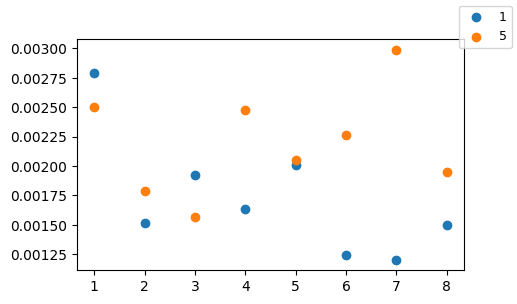

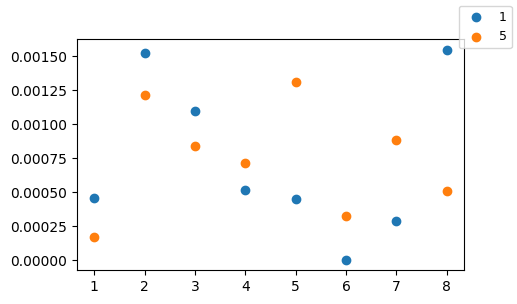

In [92]:
for i_n in np.arange(sp_avg_features[0].shape[1])[np.array(color_selec_neu)]:
    fig, ax = plt.subplots(figsize = (5,3))
    y_avg1 = sp_avg_features[0][:,i_n]#np.mean(sp_avg_all,axis=1)
    y_avg5 = sp_avg_features[1][:,i_n]
 
    rad, ang = circular_stats.mean_vector(
        radius=norm_fr_max[significant],
        angle=fr_angle_rad[:-1][significant],
    )

    ax.scatter(np.arange(1,9),y_avg1,label='1')
    ax.scatter(np.arange(1,9),y_avg5,label='5')
    fig.legend(fontsize=9)

In [82]:
plt.close()

In [83]:
# 1 aligne sample presentation
# 2 split by sample 
# 3 compute avg (throw time) for each sample
# 4 compute t-test 

In [84]:
sp_avg_all = []

for n_bhv,n_sp in zip(paths_bhv[7:8],paths_sp[7:8]):
    
    feature = 'c1'
    op_feature = 'c5'
    orientation = 0
    color = 1
    color_orient = color
    stim_num=['1','2','3','4','5','6','7','8']

    # Read data
    data = SpikeData.from_python_hdf5(n_sp)
    bhv = BhvData.from_python_hdf5(n_bhv)
    task, trial_idx = get_task_variables(data,bhv)
    
    # Select trials with more than one trial
    task = task[task['n_test_stimuli'] > 1]
    test_stimuli,code_numbers,code_samples,sp_samples,sample_trials = get_trials_by_sample(task,feature,trial_idx,bhv,data)
    test_stimuli = delete_match(test_stimuli)

    shift_sp = []
    for i in stim_num:
        i_trial, i_test = np.where(np.char.find(test_stimuli,i)==color_orient)
        tests_on = code_samples[i_trial,i_test+6].astype(int)
        sp_stim = sp_samples[i_trial]
        shifts = tests_on[:,np.newaxis]
        shift_sp.append(SpikeData.indep_roll(sp_stim, -shifts, axis=2)[:,np.array(color_selec_neu), :450].mean(axis=0))
    shift_sp=np.array(shift_sp)

    sp_avg = moving_average(data=np.array(shift_sp),win=100, step=1) 
    neurons_max = np.max(sp_avg,axis=0)
    neurons_max = np.where(neurons_max==0,1,neurons_max)
    neurons_max = neurons_max[np.newaxis,:]
    sp_avg = sp_avg/(neurons_max)
    sp_avg_all.append(sp_avg)
sp_avg_all = np.concatenate(sp_avg_all,axis=1)

/tmp/ipykernel_132729/4054691977.py:6: RuntimeWarning: invalid value encountered in cast
  test_stimuli = np.where(good_tr,test_stimuli,np.nan).astype(str)


In [85]:
stim_num

['1', '2', '3', '4', '5', '6', '7', '8']

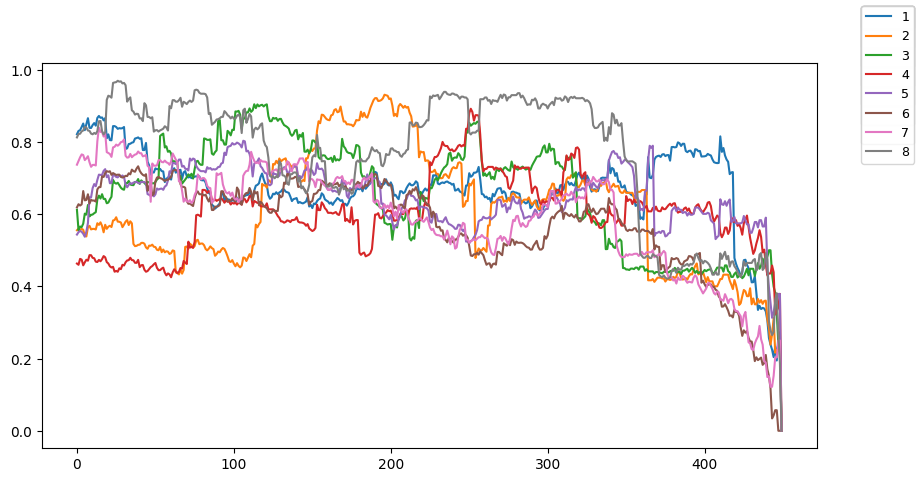

In [86]:
fig, ax = plt.subplots(figsize = (10,5))
y_avg = np.mean(sp_avg_all,axis=1)
for i,orient in enumerate(stim_num):
    y = y_avg[i] #[i_neuron]
    ax.plot(y,label=orient)
    fig.legend(fontsize=9)

In [87]:
sp_avg_all.shape

(8, 4, 450)